In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import copy, csv
import math
import random as rndm
import networkx as nx
from collections import deque, namedtuple
from math import inf
from types import SimpleNamespace
import signal

# numProc = 3
# alfa = 0.5 # height vs width of DAG
# beta = 0.5 # heterogenity factor
# tasks_count = 20
# ccr = 2.0 # cost to communication ratio
edge_weight_range = [1,100]
mean_outdeg = 2
sd_outdeg = 1

class graph_node:
	def __init__ (self, task_id, level,out_count):
		self.outgoing_edge_count =out_count 
		self.outgoing_edge_node = []
		self.outgoing_edge_weight = []
		self.level = level
		self.task_id = task_id
		self.resource_exe_time = []

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

ScheduleEvent = namedtuple('ScheduleEvent', 'task start end proc')

In [ ]:
def levels_generate(numNodes, alfa):
    rest_nodes=numNodes
    count_per_part = [1]
    while(rest_nodes>0):
        ntl=min(math.ceil(2*alfa*math.sqrt(numNodes)*np.random.random(1)[0]),rest_nodes)
#         print(ntl)
        count_per_part.extend([ntl])
        rest_nodes = rest_nodes - ntl
    count_per_part.extend([1])
    return count_per_part

def split_number(number, parts):
    count_per_part = []
    while len(count_per_part) == 0:
        for i in range(parts - 1):
            tmp1 = (number-sum(count_per_part))/(parts - i)
            tmp2 = 0
            while tmp2<=0:
                    tmp2 = int(rndm.normalvariate(tmp1, tmp1/2))
            count_per_part.extend([tmp2])
        count_per_part.extend([number-sum(count_per_part)])
        if min(count_per_part) <= 0 :
            count_per_part = []
    return count_per_part

def generate_edges(node_count_per_level, graph_height):
    level_nodes_list = []
    nodes_list = []
    count = 0
    #connect nodes in adjacent level #assign the number of edges (to each node) in each level to connect with adjacent level
    for level in range(len(node_count_per_level)):
        tmp1 = []
        elem = node_count_per_level[level]
        out_edge_count_to_next_level = []
        if level != len(node_count_per_level) -1 :
            if elem > node_count_per_level[level+1]	:
                out_edge_count_to_next_level = split_number(elem,elem)
            else :
                out_edge_count_to_next_level = split_number(node_count_per_level[level+1] , elem)
        else:
            out_edge_count_to_next_level = list(np.zeros((elem)))
            
        for i in range(elem):
            tmp1.extend([graph_node(count, level, int(out_edge_count_to_next_level[i]))])
            count = count + 1
        for elem1 in tmp1:
            nodes_list.extend([elem1])
        level_nodes_list.append(tmp1)	
    tmp = 0
    #make actual connections among the nodes in adjacent levels
    while tmp != graph_height:
        l1 = []
        l0 = []
        for elem in nodes_list:
            if elem.level == tmp+1:
                l1.extend([elem.task_id])
            if elem.level == tmp:
                l0.extend([elem.task_id])
            
        l1_tmp = copy.deepcopy(l1)
        for elem in l0:
            for elem1 in range(nodes_list[elem].outgoing_edge_count):
                tmp1 = rndm.choice(l1_tmp) 
                nodes_list[elem].outgoing_edge_node.extend([tmp1])
                nodes_list[elem].outgoing_edge_weight.extend([rndm.randint(edge_weight_range[0], edge_weight_range[1])])
                l1_tmp.remove(tmp1)
                if len(l1_tmp)	== 0:
                    l1_tmp = copy.deepcopy(l1)
        tmp =tmp + 1					
    ##add more edges to each node to ensure the connections among multiple levels
    for elem in nodes_list:
        if ((elem.level == (graph_height-1)) or (elem.level == (graph_height-2)) or (elem.level == 0)):
            continue
        current_node_level = elem.level
        remaining_nodes = 0
        l1 = []
        for elem1 in nodes_list:
            if elem1.level > elem.level and elem1 not in elem.outgoing_edge_node:
                l1.extend([elem1.task_id])
        # for elem1 in elem.outgoing_edge_node :# 	l1.remove(elem1)
        remaining_nodes = len(l1)
        tmp1 = 0
        while (tmp1 <= 0) or (tmp1 > remaining_nodes) :
            tmp1 = int(np.random.normal(mean_outdeg, sd_outdeg))
        if (elem.outgoing_edge_count >= tmp1):
            continue
        new_nodes_to_connect = []
        for i in range (tmp1 - elem.outgoing_edge_count):
            tmp2 = rndm.choice(l1)	
            l1.remove(tmp2)
            new_nodes_to_connect.extend([tmp2])
        elem.outgoing_edge_count = elem.outgoing_edge_count + len(new_nodes_to_connect)
        for elem1 in new_nodes_to_connect :
            elem.outgoing_edge_node.extend([elem1])
            elem.outgoing_edge_weight.extend([rndm.randint(1,100)])
    return nodes_list


def proc_comm_generate(numProc):
    proc_comm_bandwidth = np.zeros((numProc,numProc))
    for i in range(numProc):
        for j in range(i+1):
            if i == j:
                continue
            else:
                # proc_comm_bandwidth[i][j] = rndm.randint(bw_range[0],bw_range[1])
                proc_comm_bandwidth[i][j] = 1
                proc_comm_bandwidth[j][i] = proc_comm_bandwidth[i][j] 
    return proc_comm_bandwidth

	
def assign_computation_costs(proc_comm_bandwidth, nodes_list, ccr, beta):
    link_bw = [] 
    for i in range(len(proc_comm_bandwidth)):	
        for j in range(len(proc_comm_bandwidth[i])):
            if (i==j):
                break
            else:
                link_bw.extend([proc_comm_bandwidth[i][j]])
    #assign computation time to each node on different resources
    for elem in nodes_list:
        #find maximum data transfer
        max_weight = -1
        if elem.outgoing_edge_count == 0:
            average_com_time = float(rndm.randint(edge_weight_range[0], edge_weight_range[1]))/ float(1)
        else :
            for tmp in elem.outgoing_edge_weight:
                if tmp > max_weight:
                    max_weight = tmp
            com_time= [float(max_weight)/float(bw) for bw in link_bw]
            average_com_time = sum(com_time)/float(len(com_time))
            
        mean_comp_time = float(average_com_time) / float(ccr)
        numProc = len(proc_comm_bandwidth) 
        exe_time = []
        beta=beta/2
        if beta==0:
            exe_time = [mean_comp_time for et in range(numProc)]
        else:
            lb = mean_comp_time - (beta*mean_comp_time)
            ub = mean_comp_time + (beta*mean_comp_time)
            exe_time = np.random.uniform(lb,ub, numProc)
        elem.resource_exe_time = exe_time	
    return nodes_list

In [ ]:
def schedule_dag(dag, computation_matrix, communication_matrix):

    _self = {
        'computation_matrix': computation_matrix,
        'communication_matrix': communication_matrix,
        'task_schedules': {},
        'root_node': None,
        'optimistic_cost_table': None,
        'sorted_nodes': []
    }
    _self = SimpleNamespace(**_self)
    
    for node in dag.nodes():
        _self.task_schedules[node] = None

    root_node = [node for node in dag.nodes() if not any(True for _ in dag.predecessors(node))]
    assert len(root_node) == 1, f"Expected a single root node, found {len(root_node)}"
    root_node = root_node[0]
    _self.root_node = root_node

    _self.optimistic_cost_table = _compute_optimistic_cost_table(_self, dag)

    # _self.sorted_nodes = sort_nodes_rank(dag)
    _self.sorted_nodes = sorted(dag.nodes(), key=lambda node: dag.nodes()[node]['rank_peft'], reverse=True)
#     print(_self.sorted_nodes)
    return peft_map(dag, _self)

def schedule_dag_psls(dag, computation_matrix, communication_matrix, makespan1, peft_schedules):

    _self = {
        'computation_matrix': computation_matrix,
        'communication_matrix': communication_matrix,
        'task_schedules': {},
        'root_node': None,
        'optimistic_cost_table': None,
        'sorted_nodes': [],
        'makespan1': makespan1,
        'peft_schedules': peft_schedules
    }
    _self = SimpleNamespace(**_self)

    for node in dag.nodes():
        _self.task_schedules[node] = None
    root_node = [node for node in dag.nodes() if not any(True for _ in dag.predecessors(node))]
    assert len(root_node) == 1, f"Expected a single root node, found {len(root_node)}"
    root_node = root_node[0]
    _self.root_node = root_node

    _self.optimistic_cost_table = _compute_downward_length_table(_self, dag)

    _self.sorted_nodes = sorted(dag.nodes(), key=lambda node: dag.nodes()[node]['rank_psls'], reverse=True)
#     print(_self.sorted_nodes)
    return peft_map(dag, _self)

def sort_nodes_rank(dag):
    rank_table = {}
    terminal_node = [node for node in dag.nodes() if not any(True for _ in dag.successors(node))]
    terminal_node = terminal_node[0]
    rank_table[terminal_node] = 0
    nx.set_node_attributes(dag, { terminal_node: 0 }, "rank_dep")
    visit_queue = deque(dag.predecessors(terminal_node))
    node_can_be_processed = lambda node: all(successor in rank_table for successor in dag.successors(node))
    while visit_queue:
        node = visit_queue.pop()
        while node_can_be_processed(node) is not True:
            try:
                node2 = visit_queue.pop()
            except IndexError:
                raise RuntimeError(f"Node {node} cannot be processed, and there are no other nodes in the queue to process instead!")
            visit_queue.appendleft(node)
            node = node2
        succ_ranks = []
        for succnode in dag.successors(node):
            succ_ranks.append(rank_table[succnode] + dag[node][succnode]['weight'])
        rank_table[node] = max(succ_ranks)
        nx.set_node_attributes(dag, { node: rank_table[node] }, "rank_dep")
        visit_queue.extendleft([prednode for prednode in dag.predecessors(node) if prednode not in visit_queue])
    sorted_nodes = sorted(dag.nodes(), key=lambda node: dag.nodes()[node]['rank_dep'], reverse=True)
    return sorted_nodes
   
    
#     print(sorted_nodes)
    ##################333\
def peft_map(dag, _self ):
    procs = len(_self.communication_matrix)
    avail=np.zeros(procs)
    gap=np.zeros((procs,3*len(_self.sorted_nodes)))
    gap_point=np.ones(procs)

    for node in _self.sorted_nodes:
#         if _self.task_schedules[node] is not None:
#             continue
        est=np.zeros(procs)
        eft=np.zeros(procs)
        pred = list(dag.predecessors(node))
        if len(pred) == 0:
            est = avail
        else:
            for proc in range(procs): 
                est_pred=[]
                for prednode in pred:
                    predjob = _self.task_schedules[prednode]
                    if predjob == None:
                        predjob = ScheduleEvent(prednode, 0, 0, -1)
                    if predjob.proc == proc:
                        est_pred.append(predjob.end)
                    else:
                        est_pred.append(predjob.end + dag[prednode][node]['weight'] )
                est_pred_max=max(est_pred)
                x = 0
                isgap = 0
                
                while gap[2][x]!=0 and isgap==0 and x<3*len(_self.sorted_nodes):
                    computation_time = _self.computation_matrix[node, proc]
                    if gap[2][x]>=computation_time and (gap[1][x]-computation_time)>=est_pred_max:
                        isgap = 1
                        est[proc]=est_pred_max
                    x += 1
                if isgap==0:
                    est[proc]=max(avail[proc],max(est_pred))
        for proc in range(procs):
            eft[proc]=est[proc] + _self.computation_matrix[node, proc]
        minTaskSchedule = ScheduleEvent(node, inf, inf, -1)
        minOptimisticCost = inf
#         print(f'node: {node}, est: {est}, eft: {eft}')
        for proc in range(procs):
            taskschedule = ScheduleEvent(node, est[proc], eft[proc], proc)
            if (taskschedule.end + _self.optimistic_cost_table[node][proc] < minTaskSchedule.end + minOptimisticCost):
                minTaskSchedule = taskschedule
                minOptimisticCost = _self.optimistic_cost_table[node][proc]
        _self.task_schedules[node] = minTaskSchedule
        if minTaskSchedule.start != avail[minTaskSchedule.proc]:
#             print(type(minTaskSchedule.proc), type(int(gap_point[minTaskSchedule.proc])))
            gpi = int(gap_point[minTaskSchedule.proc])
            gap[minTaskSchedule.proc,gpi]=avail[minTaskSchedule.proc]
            gap[minTaskSchedule.proc,gpi + 1]=minTaskSchedule.start
            gap[minTaskSchedule.proc,gpi + 2]=minTaskSchedule.start-avail[minTaskSchedule.proc]
            gap_point[minTaskSchedule.proc]=gpi+3
        avail[minTaskSchedule.proc] = minTaskSchedule.end

    makespan=max(avail)
    return  _self.task_schedules, makespan

def _compute_downward_length_table(_self, dag):
#     print(_self.makespan1, _self.peft_schedules)
    downward_length_table = {}
    diagonal_mask = np.ones(_self.communication_matrix.shape, dtype=bool)
    np.fill_diagonal(diagonal_mask, 0)
    avgCommunicationCost = np.mean(_self.communication_matrix[diagonal_mask])
    for edge in dag.edges():
        nx.set_edge_attributes(dag, { edge: float(dag.get_edge_data(*edge)['weight']) / avgCommunicationCost }, 'avgweight')

    for node in dag.nodes():
        downward_length_table[node] = _self.communication_matrix.shape[1] * [0]
        for curr_proc in range(_self.communication_matrix.shape[1]):
            if len(list(dag.successors(node)))==0:
                downward_length_table[node][curr_proc] = 0
            else:
                successor_dlts = []
                for succnode in dag.successors(node):
                    succ_proc = _self.peft_schedules[succnode].proc
                    successor_comm_cost = dag[node][succnode]['avgweight'] if curr_proc != succ_proc else 0
                    successor_dlt = _self.makespan1 - _self.peft_schedules[succnode].start + successor_comm_cost
                    successor_dlts.append(successor_dlt)
                downward_length_table[node][curr_proc] = max(successor_dlts)
        nx.set_node_attributes(dag, { node: np.mean(downward_length_table[node]) }, "rank_psls")
#         print(f'Node: {node}, dlt: {downward_length_table[node]}, rank: {np.mean(downward_length_table[node])}')
    return downward_length_table

def _compute_optimistic_cost_table(_self, dag):

    optimistic_cost_table = {}

    terminal_node = [node for node in dag.nodes() if not any(True for _ in dag.successors(node))]
    assert len(terminal_node) == 1, f"Expected a single terminal node, found {len(terminal_node)}"
    terminal_node = terminal_node[0]

    diagonal_mask = np.ones(_self.communication_matrix.shape, dtype=bool)
    np.fill_diagonal(diagonal_mask, 0)
    avgCommunicationCost = np.mean(_self.communication_matrix[diagonal_mask])
    for edge in dag.edges():
#         print(f"Assigning {edge}'s average weight based on average communication cost. {float(dag.get_edge_data(*edge)['weight'])} => {float(dag.get_edge_data(*edge)['weight']) / avgCommunicationCost}")
        nx.set_edge_attributes(dag, { edge: float(dag.get_edge_data(*edge)['weight']) / avgCommunicationCost }, 'avgweight')

    optimistic_cost_table[terminal_node] = _self.computation_matrix.shape[1] * [0]
    nx.set_node_attributes(dag, { terminal_node: 0 }, "rank_peft")
    visit_queue = deque(dag.predecessors(terminal_node))
    
    node_can_be_processed = lambda node: all(successor in optimistic_cost_table for successor in dag.successors(node))
    while visit_queue:
        node = visit_queue.pop()
        while node_can_be_processed(node) is not True:
            try:
                node2 = visit_queue.pop()
            except IndexError:
                raise RuntimeError(f"Node {node} cannot be processed, and there are no other nodes in the queue to process instead!")
            visit_queue.appendleft(node)
            node = node2
        
        optimistic_cost_table[node] = _self.computation_matrix.shape[1] * [0]
        
        for curr_proc in range(_self.computation_matrix.shape[1]):
            max_successor_oct = -inf
            for succnode in dag.successors(node):
                min_proc_oct = inf
                for succ_proc in range(_self.computation_matrix.shape[1]):
                    successor_oct = optimistic_cost_table[succnode][succ_proc]
                    successor_comp_cost = _self.computation_matrix[succnode][succ_proc]
                    successor_comm_cost = dag[node][succnode]['avgweight'] if curr_proc != succ_proc else 0
                    cost = successor_oct + successor_comp_cost + successor_comm_cost
#                     print(f"If node {node} is on {curr_proc} and successor {succnode} is on {succ_proc}, the optimistic cost entry is {cost}")
                    if cost < min_proc_oct:
                        min_proc_oct = cost
                if min_proc_oct > max_successor_oct:
                    max_successor_oct = min_proc_oct
            assert max_successor_oct != -inf, f"No node should have a maximum successor OCT of {-inf} but {node} does when looking at processor {curr_proc}"
            optimistic_cost_table[node][curr_proc] = max_successor_oct
        nx.set_node_attributes(dag, { node: np.mean(optimistic_cost_table[node]) }, "rank_peft")
        visit_queue.extendleft([prednode for prednode in dag.predecessors(node) if prednode not in visit_queue])

    return optimistic_cost_table

In [ ]:
def draw_dag(dag):
    nx.draw(dag, pos=nx.nx_pydot.graphviz_layout(dag, prog='dot'), with_labels=True)
    plt.show()

def generate_connect_matrix(nodes_list):     
    connect_matrix = np.zeros((len(nodes_list), len(nodes_list)))
    for elem in nodes_list:
        for elem1 in range(len(elem.outgoing_edge_node)):
            connect_matrix[elem.task_id][elem.outgoing_edge_node[elem1]] = elem.outgoing_edge_weight[elem1]
    return connect_matrix

def generate_exec_time_matrix(procNum, nodes_list):
    exec_time_matrix = np.zeros((len(nodes_list), procNum))
    for i in range(len(nodes_list)):
        for j in range(procNum):
            exec_time_matrix[i][j] = nodes_list[i].resource_exe_time[j]
    return exec_time_matrix

def showGanttChart(task_schedules, numProcs):
    proc_schedules = {}
    for i in range(numProcs):
        if i not in proc_schedules:
            proc_schedules[i] = []
    for schedule in (task_schedules.values()):
        proc_schedules[schedule.proc].append(schedule)
        proc_schedules[schedule.proc] = sorted(proc_schedules[schedule.proc], key=lambda schedule_event: schedule_event.end)
    # print(proc_schedules)
    processors = list(proc_schedules.keys())
    color_choices = ['red', 'blue', 'green', 'cyan', 'magenta']

    ilen=len(processors)
    pos = np.arange(0.5,ilen*0.5+0.5,0.5)
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    for idx, proc in enumerate(processors):
        for job in proc_schedules[proc]:
            ax.barh((idx*0.5)+0.5, job.end - job.start, left=job.start, height=0.3, align='center', edgecolor='black', color='white', alpha=0.95)
            ax.text(0.5 * (job.start + job.end - len(str(job.task))-0.25), (idx*0.5)+0.5 - 0.03125, job.task+1, color=color_choices[((job.task) // 10) % 5], fontweight='bold', fontsize=18, alpha=0.75)
    
    locsy, labelsy = plt.yticks(pos, processors)
    plt.ylabel('Processor', fontsize=16)
    plt.xlabel('Time', fontsize=16)
    plt.setp(labelsy, fontsize = 14)
    ax.set_ylim(ymin = -0.1, ymax = ilen*0.5+0.5)
    ax.set_xlim(xmin = -5)
    ax.grid(color = 'g', linestyle = ':', alpha=0.5)

    font = font_manager.FontProperties(size='small')
    plt.show()

In [ ]:
def metrics(dag, computation_matrix):
    score = {}
    index = {}
    for node in dag.nodes():
        if len(list(dag.predecessors(node)))==0:
            score[node] = 0
        max_pred_idx, max_pred = None, 0
        for pred in dag.predecessors(node):
            if score[pred] + dag[pred][node]['weight'] > max_pred:
                max_pred = score[pred] + dag[pred][node]['weight']
                max_pred_idx = pred
        score[node] = max_pred
        index[node] = max_pred_idx
    exit = max(score, key=score.get)
    cp = []
    cpmin = 0
    point = exit
    while True:
        cp.append(point)
        cpmin += min(computation_matrix[point])
        if not point:
            break
        point=index[point]
    return cpmin, min(np.sum(computation_matrix, axis = 0))

In [ ]:
def generateRandomDAG(tasks_count, alfa, ccr, numProc, beta):
    node_count_per_level = levels_generate(numNodes=tasks_count - 2, alfa=alfa)
    graph_height = len(node_count_per_level)
    nodes_list = generate_edges(node_count_per_level=node_count_per_level, graph_height=graph_height)
    proc_comm_data = proc_comm_generate(numProc)
    nodes_list = assign_computation_costs(proc_comm_bandwidth=proc_comm_data, nodes_list=nodes_list, ccr = ccr, beta=beta)
    connect_matrix = generate_connect_matrix(nodes_list=nodes_list)
    exec_time_matrix = generate_exec_time_matrix(procNum=numProc, nodes_list=nodes_list)
    proc_comm_matrix = proc_comm_data
    dag = nx.DiGraph(connect_matrix)
    dag.remove_edges_from([edge for edge in dag.edges() if dag.get_edge_data(*edge)['weight'] == '0.0'])
    communication_matrix=proc_comm_matrix #processor to processor communication
    computation_matrix=exec_time_matrix 
    return dag, computation_matrix, communication_matrix, connect_matrix

In [ ]:
def compute_all(tasks_count, numProc, alfa, beta, ccr, num): #main function
    dag, computation_matrix, communication_matrix, connect_matrix = generateRandomDAG(tasks_count=tasks_count, alfa=alfa, ccr=ccr, numProc=numProc, beta=beta)
    # draw_dag(dag)
    # print(connect_matrix, computation_matrix, communication_matrix)
    peft_dag, psls_dag = dag, dag
    cpmin, seqmin = metrics(dag, computation_matrix)
    peft_schedules, makespan1 = schedule_dag(dag, communication_matrix=communication_matrix, computation_matrix=computation_matrix) #PEFT
    slr_peft = float(makespan1) / cpmin
    speedup_peft = seqmin/makespan1
    psls_schedules, makespan = schedule_dag_psls(dag, communication_matrix=communication_matrix, computation_matrix=computation_matrix, peft_schedules=peft_schedules, makespan1=makespan1) #PSLS
    slr_psls = float(makespan) / cpmin
    speedup_psls = seqmin/makespan
    # print(makespan_peft, slr_peft, speedup_peft, task_schedules_peft)
    # showGanttChart(peft_schedules, len(communication_matrix))
    # showGanttChart(psls_schedules, len(communication_matrix))
    result = {
        'Sample': num, 'numNodes': tasks_count, 'numProcs': numProc, 'alfa': alfa, 'beta': beta, 'ccr': ccr, 'makespan_peft': makespan1, 'slr_peft': slr_peft, 'speedup_peft': speedup_peft, 'makespan_psls': makespan, 'slr_psls': slr_psls, 'speedup_psls': speedup_psls
    }
    return result

In [ ]:
result = compute_all(tasks_count=20, numProc=6, alfa=0.5, beta=2, ccr=0.5, num=1)
result

{'Sample': 1,
 'alfa': 0.5,
 'beta': 2,
 'ccr': 0.5,
 'makespan_peft': 1597.2219297980103,
 'makespan_psls': 1621.2232086949948,
 'numNodes': 20,
 'numProcs': 6,
 'slr_peft': 1.0590557789330302,
 'slr_psls': 1.0749700940594507,
 'speedup_peft': 1.4134425498727077,
 'speedup_psls': 1.3925173443473886}

In [ ]:
# Bulk compute metrics using parameters
taskNum_samples = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
procNum_samples = [4, 8, 16, 32]
alfa_samples = [0.1, 0.4, 0.8]
beta_samples = [0.1, 0.5, 1, 1.5, 2]
ccr_samples = [0.2, 0.5, 0.8, 1, 2]

df = pd.DataFrame(columns = ['Sample', 'numNodes', 'numProcs', 'alfa', 'beta', 'ccr', 'makespan_peft', 'slr_peft', 'speedup_peft', 'makespan_psls', 'slr_psls', 'speedup_psls'])
count = 1
fail_t = 0
fail_a = 0
for tasks_count in taskNum_samples:
    for numProc in procNum_samples:
        for alfa in alfa_samples:
            for beta in beta_samples:
                for ccr in ccr_samples:
                    try:
                      for i in range(1):
                        with timeout(seconds=3):
                            result = compute_all(tasks_count=tasks_count, numProc=numProc, alfa=alfa, beta=beta, ccr=ccr, num=count)
                            df.loc[len(df.index)] = list(result.values())
                            count += 1
                        if count%100==0:
                          print(count)
                    except TimeoutError as te:
                        fail_t +=1
                        pass
                    except AssertionError as ae:
                        fail_a +=1
#                         print(ae)
#                         print(f'Error for {tasks_count}, {numProc}, {alfa}, {beta}, {ccr}')
df 
print(f'TimeoutFails: {fail_t}, AssertionErrors: {fail_a}')
df.to_csv('sample_data/revisited_results.csv', index=False)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
TimeoutFails: 54, AssertionErrors: 0


**End of Actual submission code. These are for testing purposes.**
#########################################################


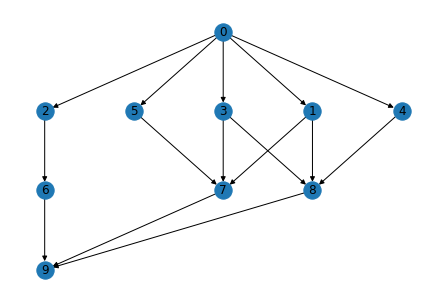

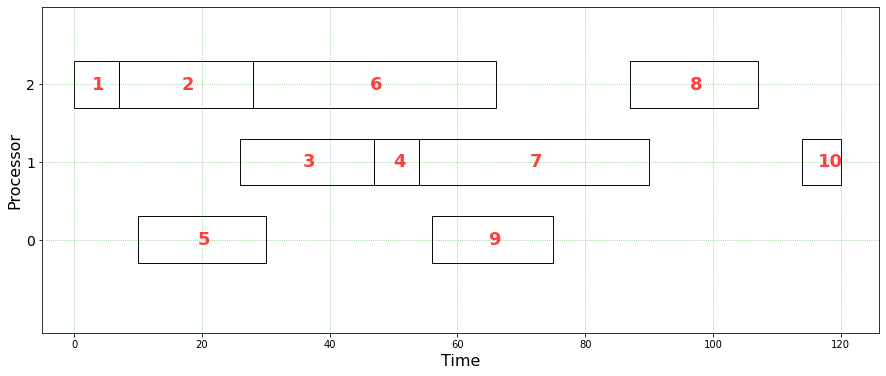

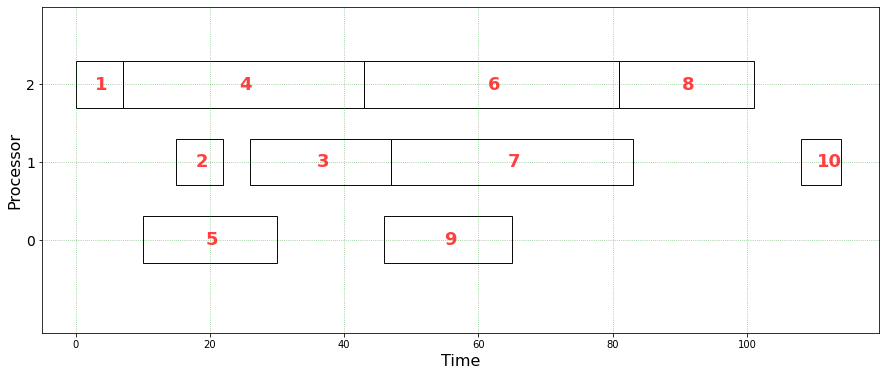


Makespan-peft: 120.0, Makespan-psls: 114.0


In [ ]:
##  To check
connect_matrix = np.array(
      [[ 0.,  8., 19., 30.,  3.,  9.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 29., 24.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 17.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 33.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
computation_matrix = np.array(
      [[17., 34.,  7.],
       [42.,  7., 21.],
       [ 8., 21., 36.],
       [27.,  7., 36.],
       [20., 26., 31.],
       [48., 46., 38.],
       [48., 36., 30.],
       [50., 27., 20.],
       [19., 31., 50.],
       [20.,  6., 31.]])
communication_matrix = np.array([[0,1,1], [1,0,1], [1,1,0]])
dag = nx.DiGraph(connect_matrix)
dag.remove_edges_from(
    [edge for edge in dag.edges() if dag.get_edge_data(*edge)['weight'] == '0.0']
)
nx.draw(dag, pos=nx.nx_pydot.graphviz_layout(dag, prog='dot'), with_labels=True)
plt.show()

peft_dag, psls_dag = dag, dag
cpmin, seqmin = metrics(dag, computation_matrix)
peft_schedules, makespan1 = schedule_dag(dag, communication_matrix=communication_matrix, computation_matrix=computation_matrix)
slr_peft = float(makespan1) / cpmin
speedup_peft = seqmin/makespan1
psls_schedules, makespan = schedule_dag_psls(dag, communication_matrix=communication_matrix, computation_matrix=computation_matrix, peft_schedules=peft_schedules, makespan1=makespan1)
slr_psls = float(makespan) / cpmin
speedup_psls = seqmin/makespan
showGanttChart(peft_schedules, len(communication_matrix))
showGanttChart(psls_schedules, len(communication_matrix))

print(f'\nMakespan-peft: {makespan1}, Makespan-psls: {makespan}')